In [9]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.gofplots import qqplot
from itertools import product 


In [2]:
df = pd.read_csv('air-passengers.csv') 
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


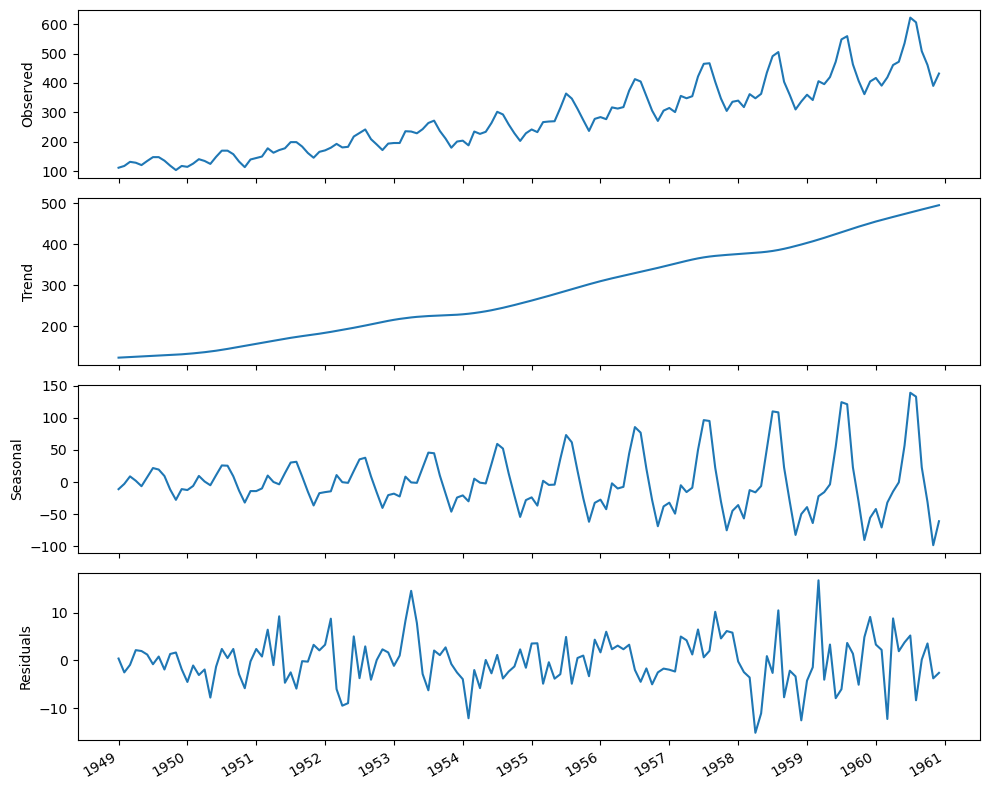

In [5]:
from statsmodels.tsa.seasonal import STL 

decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed') 

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal') 

ax4.plot(decomposition.resid) 
ax4.set_ylabel('Residuals') 

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1)) 

fig.autofmt_xdate() 
plt.tight_layout()

In [6]:
ad_fuller_result = adfuller(df['Passengers']) 

print(f'ADF Stat: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Stat: 0.8153688792060511
p-value: 0.991880243437641


In [7]:
df_diff = np.diff(df['Passengers'], n=1)
ad_fuller_result = adfuller(df_diff) 

print(f'ADF Stat: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Stat: -2.8292668241699874
p-value: 0.05421329028382711


In [8]:
df_diff2 = np.diff(df_diff, n=1)
ad_fuller_result = adfuller(df_diff2) 

print(f'ADF Stat: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Stat: -16.384231542468523
p-value: 2.7328918500141235e-29


In [16]:
ps = range(0, 4, 1) 
qs = range(0, 4, 1) 
Ps = range(0, 4, 1) 
Qs = range(0, 4, 1)

d = 1
D = 1 
s = 12 

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [12]:
from typing import Union 
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame: 
    results = [] 

    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX( 
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s), 
                simple_differencing=False).fit(disp=False)
        except: 
            continue
        aic = model.aic 
        results.append([order, aic]) 
    result_df = pd.DataFrame(results) 
    result_df.columns =  ['(p, q, P, Q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df
            

In [17]:
train = df['Passengers'][:-12] 

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p, q, P, Q)",AIC
0,"(2, 1, 1, 2)",892.238185
1,"(2, 1, 2, 1)",893.861462
2,"(2, 1, 1, 3)",894.098247
3,"(1, 0, 1, 2)",894.293728
4,"(0, 1, 1, 2)",894.994390
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.470021
254,"(0, 0, 3, 0)",908.742583


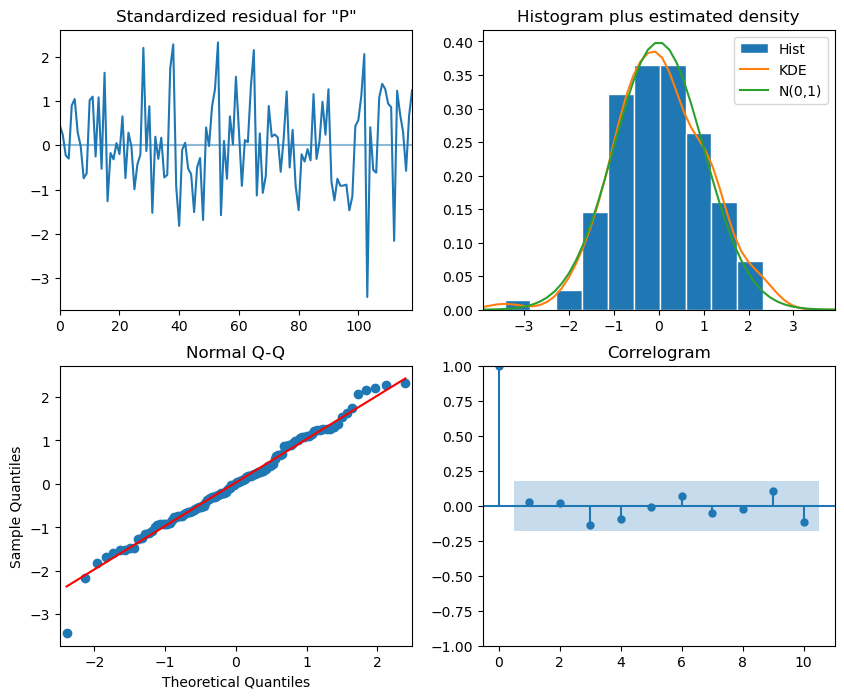

In [18]:
ARIMA_model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1,1,2,12), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [15]:
test = df.iloc[-12:] 

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values 

ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean 

test['SARIMA_pred'] = ARIMA_pred